## Permutation Feature Importance

This is used to compute feature importances for any black-box model by measuring how performance metrics decreases when a feature is not available.

### Mean decrease accuracy (MDA) : Permutaion Importance

**Approach 1**

1) Train model on original training dataset and compute the metrics

2) Remove feature from the dataset, re-train the model and check the metrics. 

3) Compute the difference between metric from step2 and step1 and check how much the performance loss has happened due to shuffling. That performance deterioration measures the importance of the variable we have just shuffled.

4) Revert the changes made in step 2

5) Go to next feature column and perform step 2 to step 4

But it requires re-training an estimator for each feature, which can be computationally intensive and my not be feasible in many cases.

**Approach 2**


The basic idea of permutation importance is to permute (shuffle) the values of each feature and measure how much that permutation negatively impacts the performance metric.This gives us a sense of how our model would perform without that specific feature. 

In this notebook we will see the practical use of this approach.
1) Train model based on training data.

2) To avoid re-training the estimator we will shuffle feature value(i.e to get noise) only from the test part of the dataset.

3) Use trained model from step 1 to make predictions using the shuffle dataset and original test data.

4) Use these predictions (Shuffled data) and the true prediction values(Original data) to calculate how much the performance loss has happened due to shuffling. That performance deterioration measures the importance of the variable we have just shuffled.

5) Revert the changes made in step 2

6) Go to next feature column and perform step 2 to step 5 

![Data](images/permutaion_imp.png)

### Mean Decrease Impurity : Random Forest
When using a tree-ensemble like random forest you can find out which features the model found valuable by checking the feature importances. In scikit-learn the feature importances are a reflection of how well a feature reduces some criterion like mean squared error for regression problem or gini / entropy for classification problem. This method for calculating feature importance is typically called mean decrease impurity.

## Import Packages

In [26]:
# Data analysis library
import numpy as np
import pandas as pd

# Machine Learning library
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Model interpretation library
import eli5
from eli5.sklearn import PermutationImportance

# Plotting library
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [27]:
print(f'Numpy version is {np.__version__}')
print(f'Pandas version is {pd.__version__}')
print(f'sklearn version is {sklearn.__version__}')
print(f'eli5 version is {eli5.__version__}')

Numpy version is 1.19.4
Pandas version is 1.1.5
sklearn version is 0.23.2
eli5 version is 0.10.1


## Download data 

### Early Stage Diabetes Risk Prediction Dataset
https://www.kaggle.com/ishandutta/early-stage-diabetes-risk-prediction-dataset

## Load data

In [28]:
## Files
data_file = '../data/early_stage_diabetes_detection/diabetes.csv'

# Load train loan dataset 
try:
    data = pd.read_csv(data_file)
    print("The dataset has {} samples with {} features.".format(*data.shape))
except:
    print("The dataset could not be loaded. Is the dataset missing?")

The dataset has 520 samples with 17 features.


## Introduction To The Data

In [29]:
data.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [30]:
data['class'].value_counts()

Positive    320
Negative    200
Name: class, dtype: int64

## Prepare data for model training

In [31]:
exclude_feature = ['class']
# Define Target columns
target = data['class'].map({"Negative": 0 , "Positive": 1})

# Define numeric and categorical features
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
numeric_features = [col for col in numeric_columns if col not in exclude_feature]
categorical_features = [col for col in categorical_columns if col not in exclude_feature]

# Define final feature list for training and validation
features = numeric_features + categorical_features
# Final data for training and validation
data = data[features]

# Split data in train and vlaidation
X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.15, random_state=10)

# Perform label encoding for categorical variable
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(X_train.loc[:, feature])
    X_train.loc[:, feature] = le.transform(X_train.loc[:, feature])
    X_valid.loc[:, feature] = le.transform(X_valid.loc[:, feature])


## Random Forest Training and evaluation

In [37]:
# Perform model training
rf_clf = RandomForestClassifier(n_estimators=300, max_depth=4, random_state=10)                               
rf_clf.fit(X_train, y_train)    
# Store Randomforest feature importance details in the dataframe for further analysis
rf_feature_importance_df = pd.DataFrame()
rf_feature_importance_df["feature"] = features
rf_feature_importance_df["importance"] = rf_clf.feature_importances_

# Perform permutaion feature importance and store details in the dataframe for further analysis
# You can choose any scoring metrics from sklearn.metrics.SCORERS.keys() for permutation importance.
perm_imp = PermutationImportance(rf_clf, scoring='roc_auc', random_state=10)
perm_imp.fit(X_valid, y_valid)
# Store Permutaion feature importance details in the dataframe for further analysis
perm_imp_df = pd.DataFrame()
perm_imp_df["feature"] = features
perm_imp_df["importance"] = perm_imp.feature_importances_

# Perform model evaluation 
rf_valid_prediction = rf_clf.predict_proba(X_valid)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_valid, rf_valid_prediction)
roc_auc = auc(fpr, tpr) # compute area under the curve
print("==============================")
print("AUC:{}".format(roc_auc))
print("==============================")

AUC:0.9931365820178448


## Permutaion Feature Importance vs Random Forest Feature Importance

Text(0.5, 1.0, 'Permutaion Feature Importance')

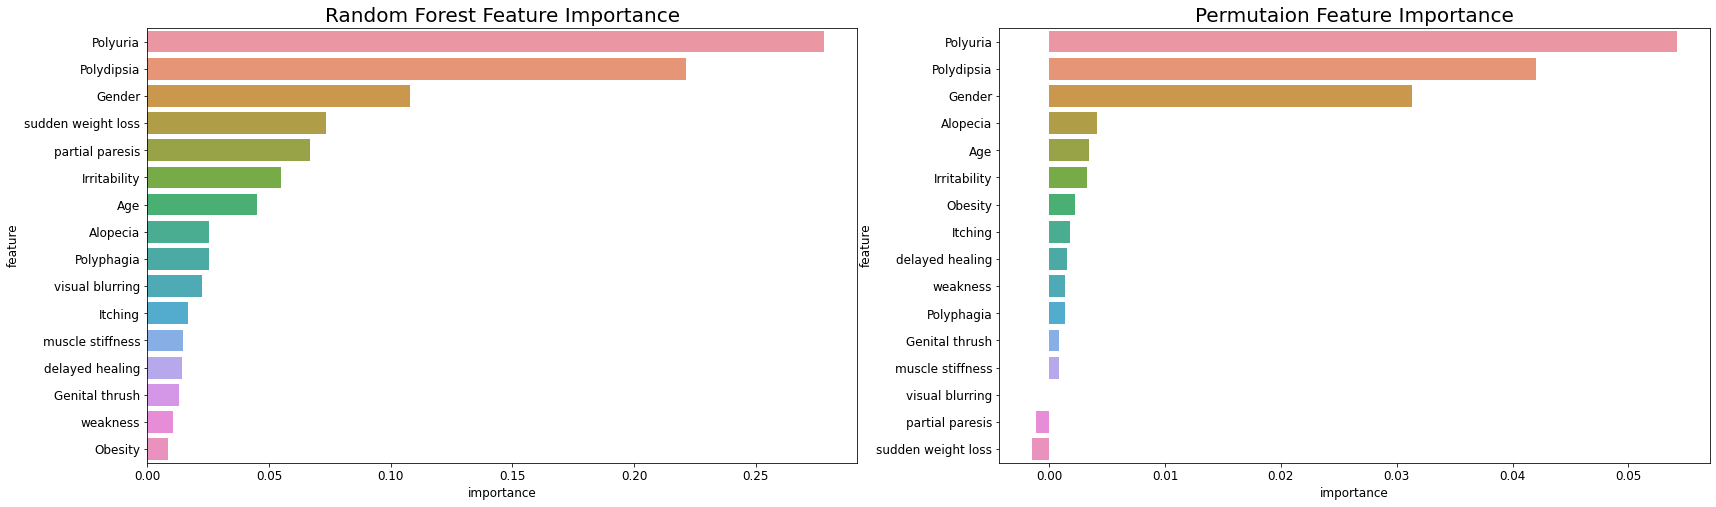

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(28,8))
plt.rcParams.update({'font.size': 12})
feature_importance_df  = rf_feature_importance_df.sort_values('importance', ascending=False).reset_index()
sns.barplot(x ='importance', y ='feature', data= feature_importance_df[:20], ax=axes[0])
axes[0].set_title("Random Forest Feature Importance", fontsize=20)

perm_feature_importance_df  = perm_imp_df.sort_values('importance', ascending=False).reset_index()
sns.barplot(x ='importance', y ='feature', data= perm_feature_importance_df[:20], ax=axes[1])
axes[1].set_title("Permutaion Feature Importance", fontsize=20)

## Permutation Importances 

In [24]:
eli5.show_weights(perm_imp, feature_names = X_valid.columns.tolist())

Weight,Feature
0.0542 ± 0.0351,Polyuria
0.0420 ± 0.0244,Polydipsia
0.0313 ± 0.0139,Gender
0.0041 ± 0.0031,Alopecia
0.0034 ± 0.0021,Age
0.0033 ± 0.0025,Irritability
0.0022 ± 0.0010,Obesity
0.0018 ± 0.0024,Itching
0.0015 ± 0.0013,delayed healing
0.0014 ± 0.0036,Polyphagia


### Interpreting Permutation Importances
The values towards the top are the most important features, and those towards the bottom matter least.

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "roc_auc" as the performance metric).

The second number measure the amount of randomness in the permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

Sometime we will see negative values for permutation importances. In those cases, the predictions on the shuffled data (which is actually a noise) happened to be more accurate than the real data. This happens when the feature didn't matter for making prediction. 

In our example, the most important features were **Polyuria, Polydipsia and Gender**. That seems sensible. 